# Waveguides - Ex8

### Ronen shekel

### ID 309987493 

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib ipympl
from scipy.optimize import fsolve
pi = np.pi 

# Q1
## A 
Given a rectangular waveguide, find $\kappa_x, \kappa_y, \gamma_x, \gamma_y$, and also $\beta$ according to both Marcatili and Kumar.  

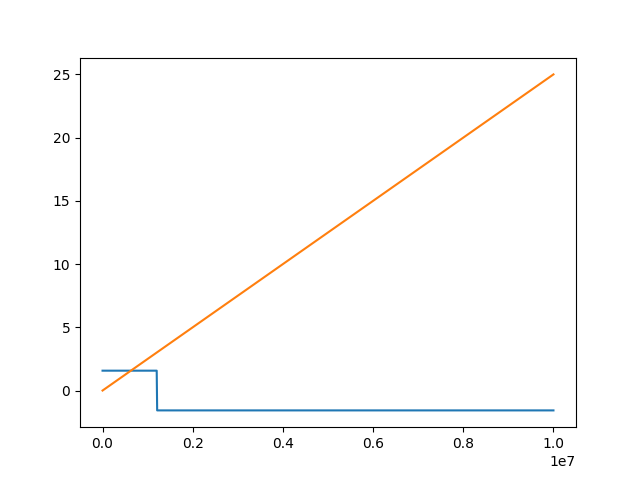

array([628318.30499215])

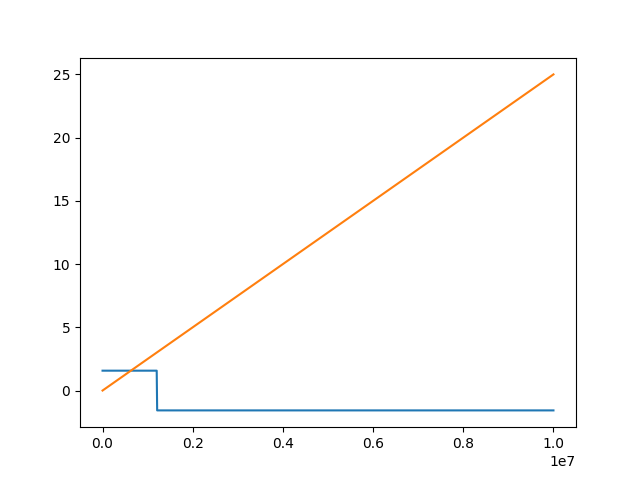

In [11]:
a = 2.5e-6
b = 3e-6 
n1 = 1.5
n0 = 1.47
wl = 1.55e-6
k0 = 2*pi/wl 

eps = np.finfo(float).eps

def get_kappa_gamma_x(a, p, n0, n1, k0, initial_guesses=0, plot=True):
    def gamma(kappa_x):
        return k0**2*(n1**2-n0**2) - kappa_x**2
    RHS = lambda k: (p-1)*(pi/2) + np.arctan((n1**2*gamma(k)) / (n0**2*k + eps))
    diff_func = lambda k: RHS(k) - k*a
    
    if plot:
        fig, ax = plt.subplots()
        X = np.linspace(0, 1e7, 1000)
        ax.plot(X, RHS(X))
        ax.plot(X, X*a)
        fig.show()
    
    return fsolve(diff_func, initial_guesses) 

p = 1
x0 = 0
get_kappa_gamma_x(a, p, n0, n1, k0, x0)

# find kx, ky with fsolve or something 
# from each kx,ky find the gamma_x, gamma_y
# also find the betas 
# check that the betas are OK: k0*n0 < beta(kx, ky) < k0*n1

# sols = fsolve(diff_func, x0=(0, 2.5, 5, 7.2))

    


## B
Draw the spatial distribution according to Kumar, together with the area of actual rectangular waveguide

In [ ]:
pass

## C
Find the b parameter from $n_{eff}$ and check whether all modes we found  are actually conducting.  

In [ ]:
pass

# Q2
## A
Calculate the basic mode according to Kumar , for $h$ values of 4,5,6,7,8 $\mu m$, where $h$ is the size of a side. 

In [ ]:
hs = np.arange(4,9) * 1e-6
n0 = 1.458
n1 = 1.47 
wl = 1.55e-6 

for h in hs:
    pass